<a href="https://colab.research.google.com/github/margaritastep/project-poetry/blob/main/%D0%A1%D1%82%D0%B5%D0%BF%D0%B0%D0%BD%D0%BE%D0%B2%D0%B0_Lab2_DL_part3_poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2

*С: Комментарий от студента: для отделения своих комментариев буду отмечать их буквой С и курсивом.*

*С: Также не уверена, отображается ли это в ноутбуке, но на всякий случай предупрежу. У данного ноутбука два автора, т.к. в процессе решения у меня закончились вычислительные ресурсы в коллабе и пришлось воспользоваться резервной почтой. У второй почты такое странное(?) название, т.к. она создавалась чисто для использования чатжпт.*

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os

In [ ]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

#from IPython.display import clear_output

import matplotlib.pyplot as plt
#%matplotlib inline
# __________end of block__________

*С: переношу на куду, чтобы быстрее считалось.*

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("{} device is available".format(device))

cuda device is available


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2024-11-16 18:48:46--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.01s   

2024-11-16 18:48:46 (7.74 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
out = ''.join(text).lower()
text = out
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


*С: я решила использовать датасет с Онегиным, т.к. мне на русском проще воспринимать результаты. В этом блоке, в целом, последовательность действий уже и так описана.*

In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2024-11-16 19:06:39--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-11-16 19:06:39 (9.91 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
out = ''.join(text).lower()
text = out

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here
tokens_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

*С: из всего датасета текстов я генерирую массив входных данных для обучения нейросети: для каждой буквы (начиная с seq_length) записываю предыдущие seq_length символов. Последовательность seq_length символов будет входными данными, а следующий за последовательностью символ - таргетом.*

In [ ]:
seq_length = 100
step = 1
sentences = []
next_chars = []

for i in range(0, len(text) - seq_length, step):
    sentences.append(text[i: i + seq_length])
    next_chars.append(text[i + seq_length])

sentences = np.array(sentences)
next_chars = np.array(next_chars)

print(sentences[:5])
print(next_chars[:5])
print('Number of sequences:', len(sentences))

['\ni\n\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдум'
 'i\n\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдума'
 '\n\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумат'
 '\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать'
 '«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать ']
['а' 'т' 'ь' ' ' 'н']
Number of sequences: 141788


*С: эта функция превращает датасет выше из букв в числа в соответствии с нашими токенами.*

In [ ]:
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences), seq_length))
    y = np.zeros((len(sentences)))

    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = tokens_to_idx[char]
        y[i] = tokens_to_idx[next_chars[i]]
    return X, y

In [ ]:
train_x, train_y = getdata(sentences, next_chars)
print('Shape of train_x:', train_x.shape)
print('Shape of train_y:', train_y.shape)

Shape of train_x: (141788, 100)
Shape of train_y: (141788,)


In [ ]:
X_train_tensor = torch.tensor(train_x, dtype=torch.long).to(device)
Y_train_tensor = torch.tensor(train_y, dtype=torch.long).to(device)

*С: Размер бача 64.*

In [ ]:
batch_size = 64

*С: делаю генератор, который будет выдавать рандомные элементы из обучающей выборки.*

In [ ]:
from torch.utils.data import DataLoader

train = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)

*С: Размер слоёв эмбединга и скрытых слоёв RNN.*

In [ ]:
emb_size = 64
hid_size = 128

*С: создаю нейросеть. В ней 2 слоя, слой эмбединга, линейный слой на выходе, есть дропаут. Т.к. начинала делать д/з до семинара, использовала также отдельно функцию задания hidden слоя, хотя можно было обойтись и без него.*

In [ ]:
class CharRNNLoop(nn.Module):
  def __init__(self, num_tokens=len(tokens), emb_size=emb_size, rnn_num_units=hid_size, n_layer = 2, dropout=0.2):
    super(self.__class__, self).__init__()
    self.n_layer = n_layer
    self.hid_size = rnn_num_units
    torch.manual_seed(42)
    self.emb = nn.Embedding(num_tokens, emb_size)
    self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True, dropout=dropout, num_layers=n_layer)
    self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
  def forward(self, x, hidden):
    embedded = self.emb(x)
    h_seq, hidden = self.rnn(embedded, hidden)
    next_logits = self.hid_to_logits(h_seq)[:, -1]
    next_logp = F.log_softmax(next_logits, dim=-1)
    return next_logp, hidden
  def initial_state(self, b_size):
    return torch.zeros(self.n_layer, b_size, self.hid_size, requires_grad=True)

*С: создаю модель, перебрасываю на куду.*

In [ ]:
model = CharRNNLoop(len(tokens), 128, 64)
model = model.to(device)
model

CharRNNLoop(
  (emb): Embedding(83, 128)
  (rnn): RNN(128, 64, num_layers=2, batch_first=True, dropout=0.2)
  (hid_to_logits): Linear(in_features=64, out_features=83, bias=True)
)

*С: несколько функций для проверки размерностей, т.к. с этим мне пришлось довольно долго повозиться.*

In [ ]:
for data, y in train_loader:
    print(data[0])
    print(y[0])
    break

tensor([ 0, 26,  0,  0, 43, 57, 59, 54,  1, 49, 76, 49, 76,  1, 62, 45, 57, 72,
        66,  1, 68, 50, 62, 63, 58, 72, 66,  1, 60, 61, 45, 47, 53, 56,  5,  0,
        55, 59, 48, 49, 45,  1, 58, 50,  1, 47,  1, 69, 64, 63, 55, 64,  1, 52,
        45, 58, 50, 57, 59, 48,  5,  0, 59, 58,  1, 64, 47, 45, 51, 45, 63, 73,
         1, 62, 50, 46, 76,  1, 52, 45, 62, 63, 45, 47, 53, 56,  0, 53,  1, 56,
        64, 68, 69, 50,  1, 47, 72, 49, 64, 57], device='cuda:0')
tensor(45, device='cuda:0')


In [ ]:
data.shape

torch.Size([64, 100])

*С: проверка того, что модель "кушает" входные данные и выдаёт результат нужного размера.*

In [ ]:
hid = model.initial_state(batch_size).to(device)
output = model(data.to(device), hid)
output[0].shape

torch.Size([64, 83])

*С: Собственно, функция обучения модели.*

In [ ]:
def train(model, crit, optim,
          train_loader,
          num_epochs=10):

    history = []

    for epoch in range(num_epochs):

        train_loss = 0

        for i, data in enumerate(train_loader): #Проходим по всем объектам даталодера
            inputs, labels = data[0].to(device), data[1].to(device) #переносим на куду
            #print(inputs[0], labels[0])
            optim.zero_grad() #зануление градиента

            hidden = model.initial_state(len(inputs)).to(device) #создание исходного скрытого слоя
            outputs, hidden = model(inputs, hidden) #вычисление результата, который даёт модель

            loss = crit(outputs, labels) #подсчёт лосса

            loss.backward() #пробрасываем лосс
            optim.step() #шаг оптимизатора

            train_loss += np.sum(loss.detach().cpu().numpy()) #сохранение лосса на этом этапе

        train_loss /= len(train_loader)
        history.append(train_loss)

        print(f"Epoch {epoch + 1} of {num_epochs}", end='')
        print(f"  train loss: {train_loss:.3f}")


    return model, history

*С: критерий - кросс-энтропия, т.к. у нас многоклассовая классификация. Оптимизатор - Адам. Обучение модели. Пусть будет 15 эпох, LSTM потом всё равно получится лучше.*

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, history = train(
    model, criterion, optimizer,
    train_loader,
    num_epochs=15,
)

Epoch 1 of 15  train loss: 2.555
Epoch 2 of 15  train loss: 2.325
Epoch 3 of 15  train loss: 2.257
Epoch 4 of 15  train loss: 2.216
Epoch 5 of 15  train loss: 2.190
Epoch 6 of 15  train loss: 2.170
Epoch 7 of 15  train loss: 2.153
Epoch 8 of 15  train loss: 2.139
Epoch 9 of 15  train loss: 2.131
Epoch 10 of 15  train loss: 2.120
Epoch 11 of 15  train loss: 2.114
Epoch 12 of 15  train loss: 2.107
Epoch 13 of 15  train loss: 2.099
Epoch 14 of 15  train loss: 2.097
Epoch 15 of 15  train loss: 2.092


Plot the loss function (axis X: number of epochs, axis Y: loss function).

*С: Видим, что лосс убывает по эпохам и это хорошо.*

Text(0, 0.5, 'Loss')

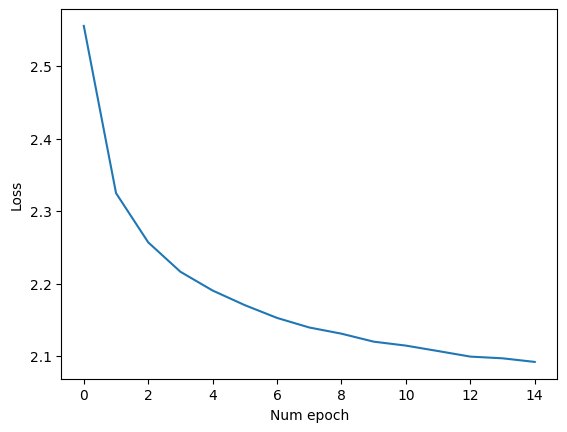

In [ ]:
# Your plot code here
x = np.arange(len(history))
plt.plot(x, history)
plt.xlabel('Num epoch')
plt.ylabel('Loss')

*С: функцию генерации пришлось немного поменять из-за проблем с батчами и размерностями. Идея та же - создаём нулевой скрытый слой, скрамливаем по символу seed фразу, далее генерим по одной букве, не забывая после каждой буквы обновлять скрытое состояние.*

In [ ]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=500, temperature=1.0):

    x_sequence = [tokens_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64).to(device)
    #print(x_sequence)
    hid_state = char_rnn.initial_state(1).to(device)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        #print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64).to(device)
        #print('x+seq', x_sequence.shape, 'next', next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)

    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0][0]])

*С: кстати, на Шекспире тоже попробовала, довольно забавно получается.*

In [ ]:
#print(generate_sample(char_rnn=model, seed_phrase=' the', max_length=500, temperature=1.0))

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

print(generate_sample(char_rnn=model, seed_phrase=' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правилый мек ли милы;
то придо бигин вертоскинья
и и с онегин я встреют;
и онегин вздейся встим и как теперь стрый прости я сердцная нежеством
не я можают бы с сутрать?
но мое хотства душу счастрась перапит ее же своей мой гружя! минте ментеньем
смелавай
и в сердце за не благате,
в былась и моля, он в нестро бутца благодиу
иль приметя рамет все шуть.


жадвижы кров передница, одном слогтам и бых так рассвертил в своезумии сон!

да лени моге, столь,
и страчае,
днет,
и мой 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

*С: с LSTM я повторяю с точностью то же самое, за исключением двух моментов: 1 - вместо RNN в модели пишу LSTM; 2 - из-за особенностей архитектуры в скрытом состоянии (в самой модели и потом при написании дальнейшего кода) этот слой ждёт не просто слой, а пару слоёв одинаковой размерности, что я, собственно, и добавила. Модели и функции назвала аналогично с добавкой 1, чтобы они случайно не перепутались.*

In [ ]:
class CharLSTMLoop(nn.Module):
  def __init__(self, num_tokens=len(tokens), emb_size=emb_size, rnn_num_units=hid_size, n_layer = 2, dropout=0.2):
    super(self.__class__, self).__init__()
    self.n_layer = n_layer
    self.hid_size = rnn_num_units
    torch.manual_seed(42)
    self.emb = nn.Embedding(num_tokens, emb_size)
    self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True, dropout=dropout, num_layers=n_layer)
    self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
  def forward(self, x, hidden):
    embedded = self.emb(x)
    h_seq, hidden = self.lstm(embedded, hidden)
    next_logits = self.hid_to_logits(h_seq)[:, -1]
    next_logp = F.log_softmax(next_logits, dim=-1)
    return next_logp, hidden
  def initial_state(self, b_size):
    return torch.zeros(self.n_layer, b_size, self.hid_size, requires_grad=True), torch.zeros(self.n_layer, b_size, self.hid_size, requires_grad=True)

In [ ]:
model1 = CharLSTMLoop(len(tokens), 128, 64)
model1 = model1.to(device)
model1

CharLSTMLoop(
  (emb): Embedding(83, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2)
  (hid_to_logits): Linear(in_features=64, out_features=83, bias=True)
)

In [ ]:
for data, y in train_loader:
    print(data[0])
    print(y[0])
    break

tensor([ 0, 26,  0,  0, 43, 57, 59, 54,  1, 49, 76, 49, 76,  1, 62, 45, 57, 72,
        66,  1, 68, 50, 62, 63, 58, 72, 66,  1, 60, 61, 45, 47, 53, 56,  5,  0,
        55, 59, 48, 49, 45,  1, 58, 50,  1, 47,  1, 69, 64, 63, 55, 64,  1, 52,
        45, 58, 50, 57, 59, 48,  5,  0, 59, 58,  1, 64, 47, 45, 51, 45, 63, 73,
         1, 62, 50, 46, 76,  1, 52, 45, 62, 63, 45, 47, 53, 56,  0, 53,  1, 56,
        64, 68, 69, 50,  1, 47, 72, 49, 64, 57], device='cuda:0')
tensor(45, device='cuda:0')


In [ ]:
hid = model1.initial_state(batch_size)[0].to(device), model1.initial_state(batch_size)[1].to(device)
output = model1(data.to(device), hid)
output[0].shape

torch.Size([64, 83])

In [ ]:
def train1(model, crit, optim,
          train_loader,
          num_epochs=10):

    history = []

    for epoch in range(num_epochs):

        train_loss = 0

        for i, data in enumerate(train_loader):   #тут в последнем баче 92 элемента и всё ломается
            inputs, labels = data[0].to(device), data[1].to(device)
            #print(inputs[0], labels[0])
            optim.zero_grad()

            hidden = model.initial_state(len(inputs))[0].to(device), model.initial_state(len(inputs))[1].to(device)
            outputs, hidden = model(inputs, hidden)

            loss = crit(outputs, labels)

            loss.backward()
            optim.step()

            train_loss += np.sum(loss.detach().cpu().numpy())

        train_loss /= len(train_loader)
        history.append(train_loss)

        print(f"Epoch {epoch + 1} of {num_epochs}", end='')
        print(f"  train loss: {train_loss:.3f}")


    return model, history

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

model1, history1 = train1(
    model1, criterion, optimizer,
    train_loader,
    num_epochs=50,
)

Epoch 1 of 50  train loss: 2.696
Epoch 2 of 50  train loss: 2.407
Epoch 3 of 50  train loss: 2.295
Epoch 4 of 50  train loss: 2.212
Epoch 5 of 50  train loss: 2.151
Epoch 6 of 50  train loss: 2.108
Epoch 7 of 50  train loss: 2.075
Epoch 8 of 50  train loss: 2.046
Epoch 9 of 50  train loss: 2.022
Epoch 10 of 50  train loss: 2.003
Epoch 11 of 50  train loss: 1.983
Epoch 12 of 50  train loss: 1.969
Epoch 13 of 50  train loss: 1.955
Epoch 14 of 50  train loss: 1.942
Epoch 15 of 50  train loss: 1.931
Epoch 16 of 50  train loss: 1.920
Epoch 17 of 50  train loss: 1.910
Epoch 18 of 50  train loss: 1.903
Epoch 19 of 50  train loss: 1.895
Epoch 20 of 50  train loss: 1.888
Epoch 21 of 50  train loss: 1.881
Epoch 22 of 50  train loss: 1.876
Epoch 23 of 50  train loss: 1.867
Epoch 24 of 50  train loss: 1.863
Epoch 25 of 50  train loss: 1.856
Epoch 26 of 50  train loss: 1.850
Epoch 27 of 50  train loss: 1.847
Epoch 28 of 50  train loss: 1.844
Epoch 29 of 50  train loss: 1.837
Epoch 30 of 50  train l

Text(0, 0.5, 'Loss')

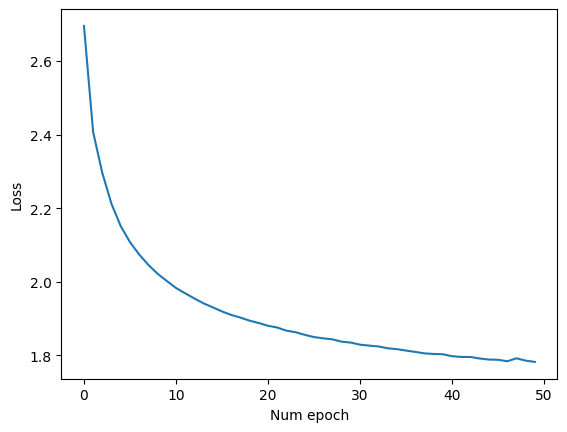

In [ ]:
# Your plot code here
x = np.arange(len(history1))
plt.plot(x, history1)
plt.xlabel('Num epoch')
plt.ylabel('Loss')

In [ ]:
def generate_sample1(char_rnn, seed_phrase=' Hello', max_length=500, temperature=1.0):

    x_sequence = [tokens_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64).to(device)
    #print(x_sequence)
    hid_state = char_rnn.initial_state(1)[0].to(device), char_rnn.initial_state(1)[1].to(device)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        #print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64).to(device)
        #print('x+seq', x_sequence.shape, 'next', next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)

    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0][0]])

In [ ]:
print(generate_sample1(char_rnn=model1, seed_phrase=' мой дядя самых честных правил', max_length=500, temperature=0.7))

 мой дядя самых честных правил
в тимель я бы с одной в седьмом
и врусти дни лорде с онегин,
и стройной прозна не отах.



xx

вы слов вам был свой час было
чеперь к ножит он двор чинатья,
но столькой я проских слабом.



xliii

что ж? но в милы страстина
он вас; так почумам испершу
сей бровин, и милы с неменье,
не без умена отхранье,
ты не добрый за больи друга,
и вашим была степрованья
чудта на пам и водров татьяне!
и дамствы примата стола…
та крестный придва с друзей, ностает,
и перед мол усты


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

*С: тут мне надоел дядя честных правил и в ход пошла татьяна в качестве seed phrase:)*

In [ ]:
# Text generation with different temperature values here
temp = [0.1, 0.2, 0.5, 1.0, 2.0]
for t in temp:
  print(f"\n-------------------------------------------------\nTemperature = {t}\nResult:\n")
  print(generate_sample1(char_rnn=model1, seed_phrase=' татьяна, русская душою', max_length=500, temperature=t))


-------------------------------------------------
Temperature = 0.1
Result:

 татьяна, русская душою
и в соседственный слез она
в так наше славить старины,
в стразная свое страсти,
и в том с ней молодой страсть
и молодой прости в страсти
и в страсти прихранный страсти
и в так с ней простой постередий
и в такой свет он он прости,
и страсти с ним страсти встречит
и в так страсти в словой страсть
и в том и так с онегина,
и в страсти страшно в страсти,
как страсти своей в соседой
и молча под нем и в страсть
в слез в там с ним с ней вас в садим,
и в сердце молодой привода,
на

-------------------------------------------------
Temperature = 0.2
Result:

 татьяна, русская душою
и там с ним в тайный страшный свет,
прости с ним молча не страсти
и в теперь света в так в томной
и в так нам с она страсной
и страсти своей страсти страсти
и в тихо с ним постерственный,
и в страшно в свет и в ней молодой
и в стариненья в страсти,
и в должны в смерть в так на странный,
и в том страшен постарий старит

*С: температура в экспоненте функции софтмакс отвечает за случайность (по факту, энтропию). Чем выше температура, тем с большей вероятностью модель выберет самый наиболее вероятный символ, и наоборот. Соответственно, тут мы видим, что при маленьком значении температуры 0.2 слова и буквы часто повторяются (почему-то модели очень понравились слова сердце и страсть). Что интересно, в этом случае в тексте больше всего рифм (долгой - странной, тольной - тёмной - приводной, из того, что получилось у меня при одном из запусков). При большом значении температуры (2.0) в тексте появляется куча символов и даже английские буквы, которых явно там быть не должно. 0.5 - 1.0 - оптимальные значения. Мне где-то на 0.7 больше всего понравилось.*

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

*С: путь и название файла.*

In [ ]:
path = 'model_lstm.pth'

In [ ]:
torch.save(model1, path)

In [ ]:
model2 = torch.load(path, weights_only=False)
model2.eval()

CharLSTMLoop(
  (emb): Embedding(83, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2)
  (hid_to_logits): Linear(in_features=64, out_features=83, bias=True)
)

In [ ]:
print(generate_sample1(char_rnn=model2, seed_phrase=' онегин', max_length=500, temperature=0.7))

 онегин?
дало своей бредит таня,
и над ним раденья, на в окном,
на душе я лунях лета,
то первый думи вздор бурена».
«в уж чужие так простом светом,
в должно раздалася на замы…



xxxvii

приважный куплив не знала,
и отпиралась когда вашей.



xli

что дева не так нет был со мой,
не прязамененных часе,
что не девы много со след!



xvi

там мать молча лун в тем уверина,
отпасным узда с оченья,
жиль был был свой постели тани
ходится, и степут приводит
читать он вдруг на молодой
вствена; онегин до 


*С: П.С. отдельное спасибо за такое интересное задание, я конечно в какой-то момент возненавидела Пушкина и ML, но в итоге очень сильно радовалась, когда модель сгенерила +- осмысленный текст, непередаваемые ощущения.*

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)